# Imports and general setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Managing secrets
from google.colab import userdata

import gc # Garbage collector
import sys
from pathlib import Path
import os
import inspect # Access to source code


Mounted at /content/drive


In [2]:
# Working directory
%cd drive/MyDrive/GitHub/reportingAgent/PoC/
%pwd

/content/drive/MyDrive/GitHub/reportingAgent/PoC


'/content/drive/MyDrive/GitHub/reportingAgent/PoC'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load SmolLM3-3B grid search test bench results



In [4]:
df = pd.read_excel('/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/Smol3B - tb and analysis/tb-HuggingFaceTB-SmolLM3-3B-17-082025_12-43-12.xlsx')

df.shape

(2880, 24)

# Study correlation among metrics

In `tb-HuggingFaceTB-SmolLM3-3B-17-082025_12-43-12.xlsx` file, 80 deviation scenarios have been used to generate reports using SmolLM3 varying the generation parameters (3 different prompts, 4 levels of temperature and 3 levels of top_p). The total number of generated reports is 2880.

Each generated report, has been evaluated for similarity with the reference report (ground truth). The metrics are divided in 2 groups:


* Text-level comparison:
    * BLEU: focuses on precision by comparing overlap of 1-gram to 4-grams between the 2 texts (returned values are *bleu*, and precisions for 1- to 4-grams namely *b_1_grams*, *b_2_grams*, *b_3_grams*, *b_4_grams*)
    * ROUGE: focuses on recall (returned values are *rouge1*, *rouge2*, *rougeL*, *rougeLsum*)
* Semantic-level comparison:
    * BERTScore: (returned values are *bs_precision*, *bs_recall*, *bs_f1*)
    * Bi-encoder similarity (returned value *be_sim*)
    * Cross-encoder similarity (returned value *ce_sim*)

We intend to study how these scores correlate to each other.

In [5]:
metrics = ['bs_precision',
       'bs_recall', 'bs_f1', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleu',
       'b_1_grams', 'b_2_grams', 'b_3_grams', 'b_4_grams', 'be_sim', 'ce_sim']

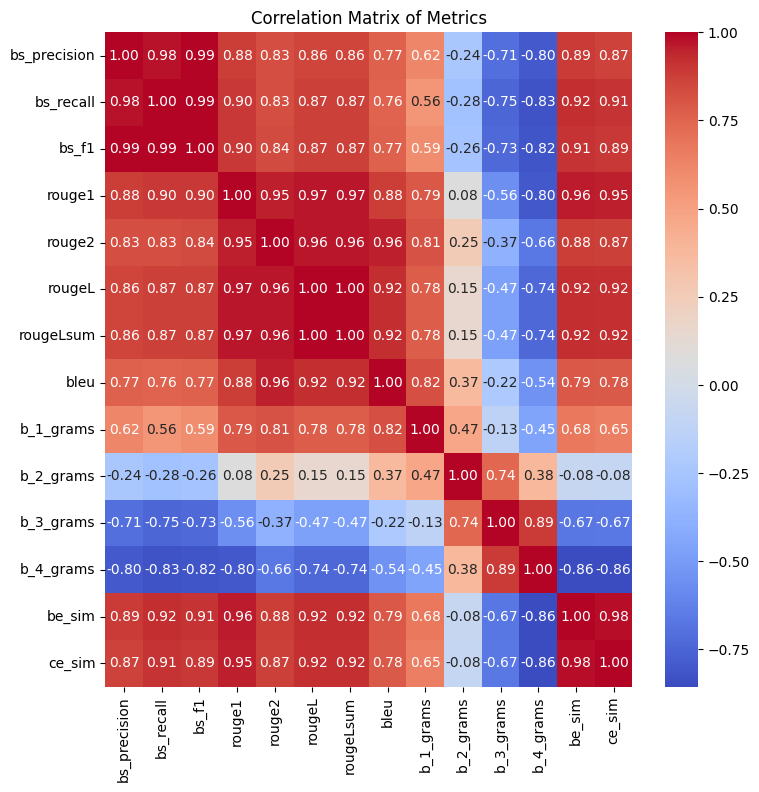

In [6]:
# Calculate the correlation matrix
corr_matrix = df[metrics].corr()

# Plot the heatmap
plt.figure(figsize=(8.5, 8.5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Metrics')
plt.show()

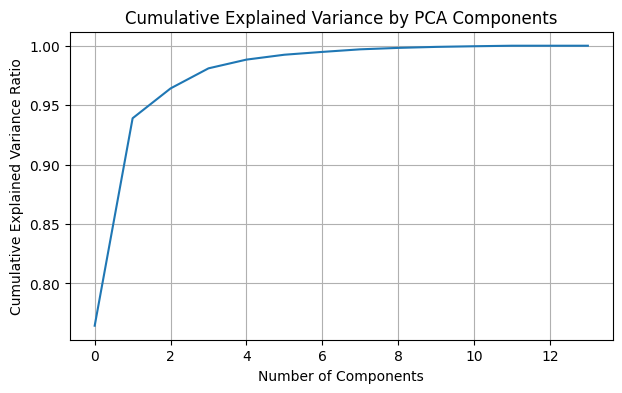

In [7]:
# Standardize the data before applying PCA
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(df[metrics])

# Apply PCA with all components to calculate cumulative explained variance
pca_full = PCA()
pca_full.fit(scaled_metrics)

# Plot cumulative explained variance
plt.figure(figsize=(7, 4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()


,Cumul. Explained Variance Ratio
PC1,0.764422
PC2,0.938975
PC3,0.964075
PC4,0.980972


/tmp/ipython-input-2593350023.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(metric, (loadings[x_axis_PC][i], loadings[y_axis_PC][i]))


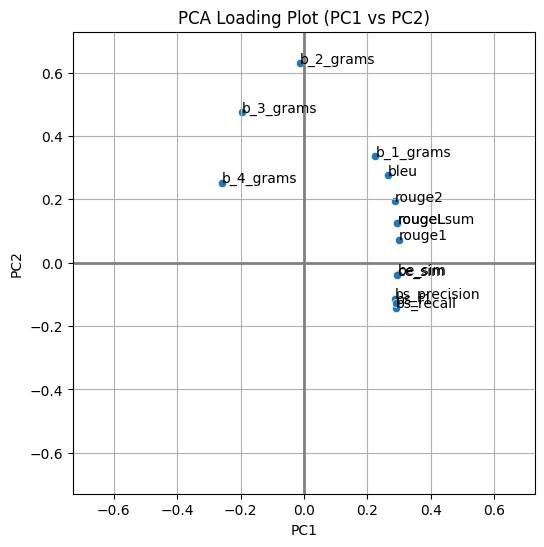

In [8]:
# Apply PCA, keeping only the first 4 components as requested before
pca = PCA(n_components=4)
pca.fit(scaled_metrics)

# Get the loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=metrics)

# Display explained variance ratio for the selected components
explained_variance_ratio = pd.DataFrame({'Cumul. Explained Variance Ratio': np.cumsum(pca.explained_variance_ratio_)}, index=[f'PC{i+1}' for i in range(pca.n_components_)])
display(explained_variance_ratio)


# Visualize the loadings (on the first two principal components)
x_axis_PC, y_axis_PC = 'PC1', 'PC2'

plt.figure(figsize=(7.5, 6))
sns.scatterplot(x=loadings[x_axis_PC], y=loadings[y_axis_PC])
plt.title(f'PCA Loading Plot ({x_axis_PC} vs {y_axis_PC})')
plt.xlabel(x_axis_PC)
plt.ylabel(y_axis_PC)

# Materialize axes at the origin
plt.axhline(0, color='grey', lw=2)
plt.axvline(0, color='grey', lw=2)

# Ensure same scale on x and y axes
max_loading = max(loadings[x_axis_PC].abs().max(), loadings[y_axis_PC].abs().max())
plt.xlim(-max_loading-.1, max_loading+.1)
plt.ylim(-max_loading-.1, max_loading+.1)
plt.gca().set_aspect('equal', adjustable='box')


# Add labels for each metric
for i, metric in enumerate(metrics):
    plt.annotate(metric, (loadings[x_axis_PC][i], loadings[y_axis_PC][i]))

plt.grid(True)
plt.show()